# 1) Backtracking

In [1]:
import numpy as np, scipy as sp, json

In [2]:
from scipy import sparse, linalg

In [3]:
from matplotlib import pyplot as plt

If you need to download the database, uncomment below and execute (Linux commands, do manually if on a different platform)

In [4]:
# !wget 'https://zenodo.org/record/4304044/files/isogeny-database-v1-30000.zip'
# !unzip 'isogeny-database-v1-30000.zip'

Load the adjacency matrix and normalize

In [5]:
A = sparse.load_npz('graphs/29989/29989_2.npz') / 3

Load the second largest eigenvalue in absolute value

In [6]:
with open('graphs/29989/29989_metadata.json') as f:
    meta = json.load(f)
λ2 = max(map(abs, meta['ell']['2']['eigenvalues']))

The normalized adjacency matrix of the clique (all 1s)

In [7]:
J = np.matrix(np.ones(A.shape) / A.shape[0])

The slope function predicted by the Ramanujan bound

In [8]:
c = lambda l : 1 / (np.log2((l+1)/np.sqrt(l)) - 1)

The log statistical distance (matrix L1 norm) between X and the clique. 

This corresponds to the maximum statistical distance from uniform, among walks that start at a given vertex. Other statistics (e.g., average statistical distance, min statistical distance, ...) could also be interesting.

In [9]:
D = lambda X : np.log2(linalg.norm(X - J, ord=1)) - 1

Let's plot the measured statistical distance against the slopes predicted by the Ramanujan bounds for walks **with backtracking**  (as the length of the walk increases). We only compare the slopes, not the additive constant, which appears to be smaller than what the bounds predict.

Of course, it'd be interesting to do the same for walks without backtracking

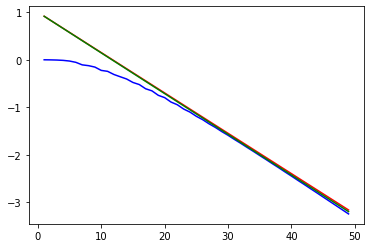

In [10]:
N = 50
B = np.matrix(A.toarray())
y = [D(B)]
for t in range(1, N-1):
    B *= A   # B is dense and A is sparse, this appears to be faster
    y.append(D(B))

x = np.arange(1,N)
plt.plot(x, y, color='blue')
plt.plot(x, -x/c(2) + 1, color='red')   # The slope predicted by the Ramanujan bound (+1 for visual aid)
plt.plot(x, -x*np.log2(3/λ2) + 1, color='green')   # The slope predicted by λ₂ (+1 for visual aid)

Same as above, but with less datapoints, so we can look further

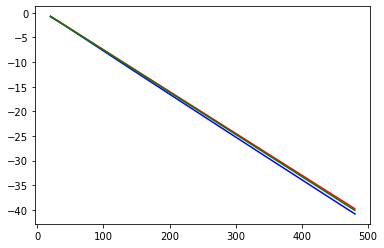

In [11]:
N, jump = 25, 20
Aj = np.matrix(A.toarray())**jump
B = Aj.copy()
y = [D(B)]
for t in range(1, N-1):
    B *= Aj
    y.append(D(B))

x = np.arange(jump, N*jump, jump)
plt.plot(x, y, color='blue')
plt.plot(x, -x/c(2) + 1, color='red')   # The slope predicted by the Ramanujan bound (+1 for visual aid)
plt.plot(x, -x*np.log2(3/λ2) + 1, color='green')   # The slope predicted by λ₂ (+1 for visual aid)

# 2) Non-backtracking

In [12]:
number_vertices = A.shape[0]

A list to index all the edges

In [13]:
edges = [(A.nonzero()[0][i],A.nonzero()[1][i]) for i in range(A.size)]

Build the transition matrix NB of non-backtracking walks (that is a walk on edges rather than on vertices)

In [14]:
NBshape = (len(edges),len(edges))
NBrow = []
NBcol = []
NBdata = []
cA = A.tocoo()
for i1,j1,v1 in zip(cA.row, cA.col, cA.data):
    for i2,j2,v2 in zip(cA.row, cA.col, cA.data):
        if (j1 == i2):
            e1 = edges.index((i1,j1))
            e2 = edges.index((i2,j2))
            x = v2*3
            if ((i2,j2) == (j1,i1)):
                x -= 1 # non-backtracking
            if (x != 0):
                NBrow.append(e2)
                NBcol.append(e1)
                NBdata.append(x/2)

In [15]:
NB = sparse.coo_matrix((NBdata,(NBrow,NBcol)),shape=NBshape).tocsr()

Build a matrix _to\_targets_ that transforms a distribution on edges in to a distribution on vertices: if v is a vector representing a distribution on the edges, then to_targets\*v is a vector representing the distribution on vertices obtained by sampling an edge and returning its target

In [16]:
to_targets = [[0 for i in range(len(edges))] for j in range(number_vertices)]
for i in range(len(edges)):
    to_targets[edges[i][1]][i] += 1

In [17]:
to_targets = np.matrix(to_targets)
target_matrix = to_targets*NB

Reshape the uniform matrix to account for all possible starting *edge* (instead of starting *vertex*)

In [18]:
#to_targets

In [19]:
J = np.matrix(np.ones(target_matrix.shape) / target_matrix.shape[0])

In [20]:
N = 50
B = np.matrix(NB.toarray())
y = [D(to_targets*B)]
for t in range(1, N-1):
    B *= NB   # B is dense and NB is sparse, this appears to be faster
    y.append(D(to_targets*B))

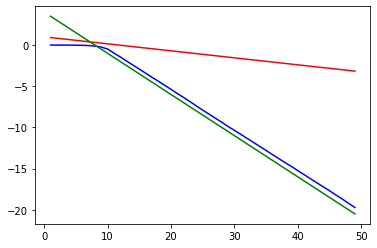

In [21]:
x = np.arange(1,N)
plt.plot(x, y, color='blue')
plt.plot(x, -x/c(2) + 1, color='red')   # The slope predicted by the Ramanujan bound for backtracking walks
plt.plot(x, -x/2. + 4, color='green')   # Some attempt to match the slope